# High cocoa prices: no sweet gains for Cameroon's productivity so far

By Douglas K. G. Araujo ([@dkgaraujo](https://www.github.com/dkgaraujo))

Increasing a country's productivity is essential to promote durable improvements in living conditions but is very difficult to do in practice. In this notebook, I explore whether the dramatically high prices that prevail in the last years for cocoa, a key export for Cameroon, are sparking necessary improvements in productivity.

Cameroon is a good case study on the effects of terms of trade shocks on productivity. For one, cocoa is the most important non-oil & gas exports for that country. Second, the current increase in prices stems from harvest problems in Côte d'Ivoire and Ghana, the two largest producers, but Cameroon cocoa supply is unharmed. Third, Cameroon like so many other countries badly needs higher levels of productivity to improve conditions for a relevant share of its population.

A long literature in economics explores the effect of high export prices - those are more generally considered a terms-of-trade shock if the price increase occurred independently of the country in question. Terms of trade shocks are thought to be very relevant, especially in lower income countries, but empirically these effects are more muted (Schmitt-Grohé and Uribe 2018). Recent evidence suggests that increases in export prices (as in this case) but not import price changes have a meaningful and last effect on the economy (Di Pace 2025).

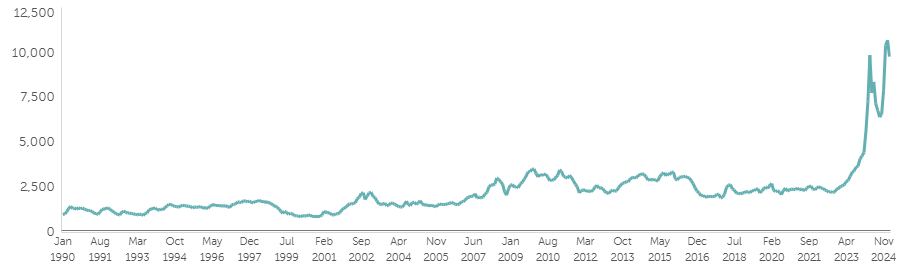

Figure: global price of cocoa, US$ per metric ton. Source: FRED Global price of Cocoa (PCOCOUSDM), originally from IMF.

The dramatic increase in cocoa prices (see figure above) can put this theory to the test. I use the "machine controls" - or synthetic controls method with machine learning (Araujo 2024) - to estimate the causal impact of the higher prices on the Cameroon economy. This method essentially uses machine learning to simulate what would happen to Cameroon if the previous cocoa prices remained the same. Armed with this, I then the difference between the actual values and their synthetic counterpart.

# Data



This work requires a dataset on productivity for a panel of countries over a meaningful span of time. One of the best international data on this theme is provided by the International Labour Organisation (ILO). ILO experts compile and estimate annual labour productivity, measured as output per worker in stable US dollars.

Thankfully, ILO offers a way to donwload the data via SDMX. In this notebook, I use gingado (Araujo 2023) to find and download the data. The code below first install gingado, then the necessary libraries.

In [2]:
pip install -q --upgrade https://github.com/bis-med-it/gingado/tarball/master

  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from gingado.utils import list_all_dataflows, load_SDMX_data
from gingado.estimators import MachineControl
from sklearn.cluster import AffinityPropagation
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE

Once the libraries are loaded, we can save in a varable the list of all SDMX dataflows that there are.

In [ ]:
dflows = list_all_dataflows(return_pandas=True)

Once with `dflows`, we can find dataflows of interest.

In [6]:
dflows[dflows.str.contains('output per worker', case=False)]

ILO  DF_GDP_205U_NOC_NB    Output per worker (GDP constant 2015 US $) -- ...
     DF_GDP_211P_NOC_NB    Output per worker (GDP constant 2021 internati...
     DF_SDG_0821_NOC_RT    SDG indicator 8.2.1 - Annual growth rate of ou...
Name: dataflow, dtype: object

gingado also offers a way to download dataflows, by passing them source (in this case, ILO) and the dataflow code, which is `DF_GDP_211P_NOC_NB`.

In [7]:
outcome_var = load_SDMX_data(
    sources={'ILO': 'DF_GDP_211P_NOC_NB'},
    keys={'FREQ': 'A'},
    params={'startPeriod': 2000, 'endPeriod': 2024}
)

Querying data from ILO's dataflow 'DF_GDP_211P_NOC_NB' - Output per worker (GDP constant 2021 international $ at PPP) -- ILO modelled estimates, Nov. 2024...


In [12]:
col_fields = pd.DataFrame([c.split("__") for c in outcome_var.columns])
for col in col_fields.columns:
    print("No of unique values for column No", col, ": ", col_fields[col].nunique())
print("\nFirst five rows:")
print(col_fields.head())

No of unique values for column No 0 :  1
No of unique values for column No 1 :  276
No of unique values for column No 2 :  1
No of unique values for column No 3 :  1

First five rows:
     0                       1  2            3
0  ILO  DF_GDP_211P_NOC_NB_AFG  A  GDP_211P_NB
1  ILO  DF_GDP_211P_NOC_NB_AGO  A  GDP_211P_NB
2  ILO  DF_GDP_211P_NOC_NB_ALB  A  GDP_211P_NB
3  ILO  DF_GDP_211P_NOC_NB_ARE  A  GDP_211P_NB
4  ILO  DF_GDP_211P_NOC_NB_ARG  A  GDP_211P_NB


In the code below, I remove Côte d'Ivoire (CIV) and Ghana (GHA) since they are the two largest cocoa producers as well as the places where harvest problems led to the big increase in cocoa prices.

In [17]:
col_filter = [
    c for c in outcome_var.columns
    if "DF_GDP_211P_NOC_NB_X" not in c
    and "DF_GDP_211P_NOC_NB_CIV" not in c
    and "DF_GDP_211P_NOC_NB_GHA" not in c
]

X = outcome_var[col_filter]
X = X.dropna(axis=1)

# cleaning out the name to remove the constant portions across all countries
X.columns = [c.replace("ILO__DF_GDP_211P_NOC_NB_", "") \
    .replace("__A__GDP_211P_NB", "") for c in X.columns]

col_CMR = [c for c in X.columns if c == "CMR"]
y = X.pop(col_CMR[0])

assert X.shape[0] == y.shape[0]

For reference, the annual labour productivty is in the graph below.

Text(0.5, 1.0, 'Annual labour productivity in Cameroon')

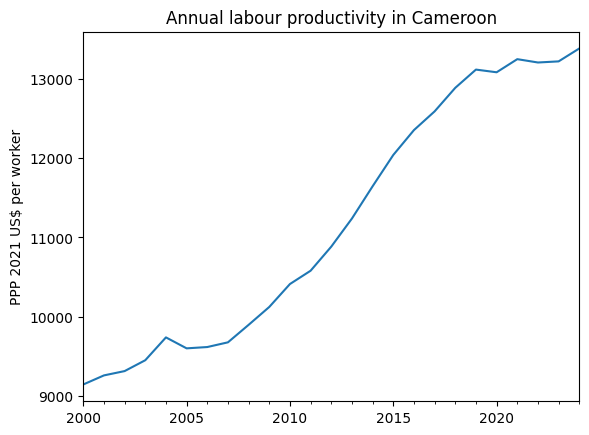

In [23]:
ylabel = 'PPP 2021 US$ per worker'

ax = y.plot(legend=False)
plt.ylabel(ylabel)
plt.xlabel('')
plt.title('Annual labour productivity in Cameroon')

In [24]:
X_pre, y_pre = X[:'2022-12-31'], y[:'2022-12-31']

assert X_pre.shape[0] == y_pre.shape[0]
X_pre.shape, y_pre.shape

((23, 181), (23,))

# Estimating the causal effect with "machine controls"

The gingado library enables an easy estimation of the "machine controls" discussed above. Essentially, they consist of three parts. First, a cluster algorithm that finds comparable countries. Second, an estimator (in this case, a random forest) to learn how to forecast Cameroon before the high cocoa prices. And finally, a manifold learning algorithm summarises all this new information and allows easier evaluation of the quality of the machine controls.

In [25]:
synth_CMR = MachineControl(
    cluster_alg=AffinityPropagation(max_iter=10_000),
    estimator=RandomForestRegressor(),
    manifold=TSNE(perplexity=5)
)

In [26]:
synth_CMR.fit(X_pre, y_pre)

MachineControl(cluster_alg=AffinityPropagation(max_iter=10000),
               estimator=RandomForestRegressor(), manifold=TSNE(perplexity=5))

The control group, found in a data-driven way, are the countries in the list below. They are the most similar to one another as a group, and therefore can help estimate Cameroon much easier.

In [28]:
" ".join(synth_CMR.donor_pool_)

'AFG BDI BEN BFA BGD BOL CAF COD COM ERI ESH ETH GIN GMB GNB HND HTI IND KEN KGZ KHM LAO LBR LSO MDA MDG MLI MMR MOZ MWI NER NGA NIC NPL PAK PHL PNG PRK RWA SEN SLB SLE SOM SYR TCD TGO TJK TLS TON TZA UGA UZB VNM VUT ZMB ZWE'

To check whether this control group is indeed similar to Cameroon is as easy as plotting it. Below is the trajectory for labour productivity in the last 25 years.

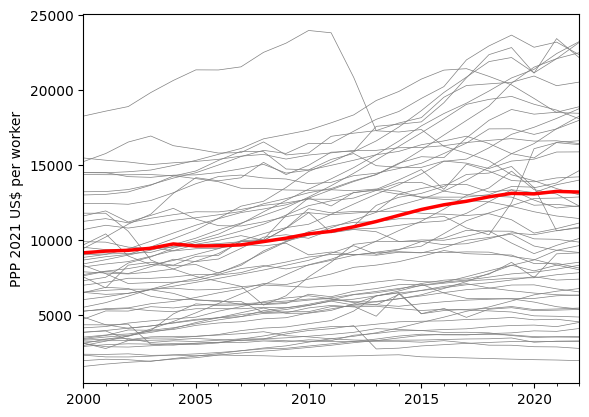

In [39]:
ylabel = 'PPP 2021 US$ per worker'

ax = X_pre[synth_CMR.donor_pool_].plot(legend=False, color="grey", linewidth=0.5)
y_pre.plot(ax=ax, color="red", linewidth=2.5)

plt.ylabel(ylabel)
plt.xlabel('')
plt.show()

One way to formally check is to summarise each country's labour productivity in a 2x2 plot, in a way that countries that are more similar throughout all the sample will be closer.

In the plot below, all the other countries in the control group are grey. Actual Cameroon is blue and the synthetic "machine control" Cameroon that did not experience the high in cocoa prices is in red.

<ipython-input-30-d0ae7266010a>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


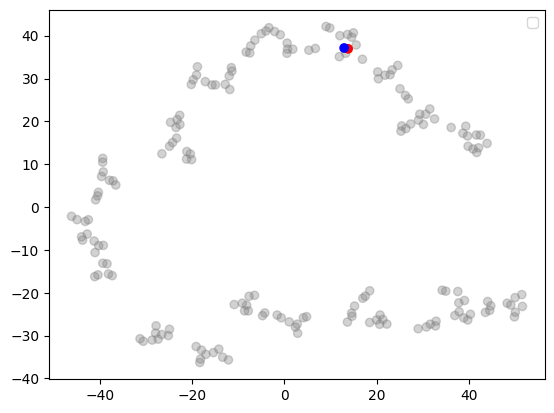

In [30]:
colors = [(0.5, 0.5, 0.5, 0.35)] * X.shape[1] + ['red', 'blue']

fig, ax = plt.subplots()
ax.scatter(
    synth_CMR.manifold_embed_[:, 0], synth_CMR.manifold_embed_[:, 1],
    color=colors,
    )
ax.legend()
plt.show()

See how close they are - in fact, synthetic Cameroon (before the cocoa price increase) is very, very close to the actual camerroon.

In [31]:
synth_CMR.control_quality_test_ / 100

np.float64(0.018668719748064742)

# Results

According to the data and this model - which assumes Cameroon without high cocoa prices would continue behaving as it did in the last years - productivity would be lower absent this recent windfall.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


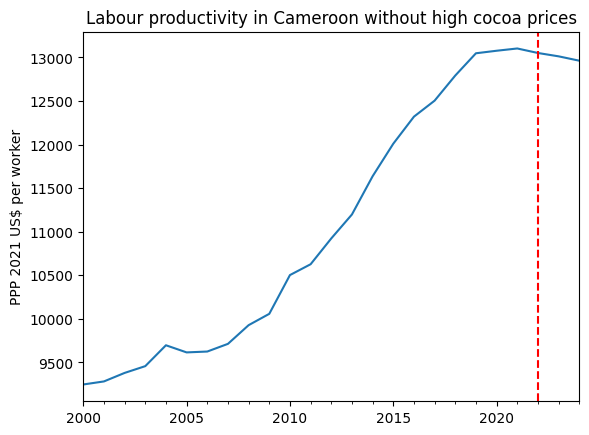

In [40]:
ax = synth_CMR.predict(X, y).plot(legend=False)
ax.axvline(x='2022-12-31', color='r', linestyle='--')
plt.ylabel('PPP 2021 US$ per worker')
plt.xlabel('')
plt.title("Labour productivity in Cameroon without high cocoa prices")
plt.show()

In other words, actual Cameroon, which benefits from high cocoa prices, has a higher productivity than the version of Cameroon that does not. But is ths increase significant? Comparing the difference between actual and synthetic Cameroon will reveal if this effect is significant.

As shown below, the effect (red line) is not statistically different from the same study with other countries, as in a placebo (grey lines). So even if it is positive, the amount is too small to be considered really an effect from the cacao prices.

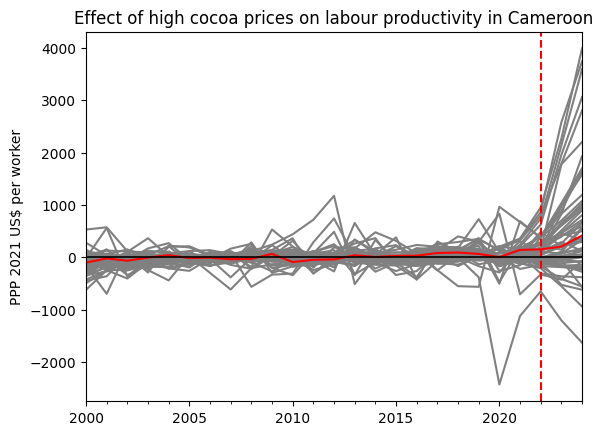

In [36]:
all_diffs = pd.concat([
    synth_CMR.placebo_diff_,
    synth_CMR.diff_
], axis=1)
colors = ['grey'] * synth_CMR.placebo_diff_.shape[1] + ['red']
y_label = 'PPP 2021 US$ per worker'
effect_title = "Effect of high cocoa prices on labour productivity in Cameroon"

ax = all_diffs.plot(legend=False, color=colors)
ax.axvline(x='2022-12-31', color='red', linestyle='--')
ax.axhline(y=0, color='black', linewidth=1.2)
plt.ylabel(y_label)
plt.xlabel('')
plt.title(effect_title)
plt.show()

# Conclusion

Unusually high cocoa prices are certainly making the headlines - in both producer and consumer countries, but the effects on the ground are more limited. In particular, average labour productivity in Cameroon is not responding to this windfall.

But this result is not necessarily mean the country will remain at current levels of productivity. Even if the Cameroonian economy is using some of its gains to improve its long-term standing, it would still take some time before macroeconomic effects are visible.

# References

Araujo, D. K. G. (2023). gingado: a machine learning library focused on economics and finance. Bank for International Settlements, BIS Working Paper No 1122.

Araujo, D. K. G. (2024). Synthetic controls with machine learning: application on the effect of labour deregulation on worker productivity in Brazil. Bank for International Settlements, BIS Working Paper No 1181.

Di Pace, Federico, Luciana Juvenal, and Ivan Petrella. (2025). Terms-of-Trade Shocks Are Not All Alike. American Economic Journal: Macroeconomics 17 (2): 24–64.

Schmitt‐Grohé, S., & Uribe, M. (2018). How important are terms‐of‐trade shocks?. International Economic Review, 59(1), 85-111.